In [1]:
%pip install transformer_lens

Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformer_lens import HookedEncoderDecoder
import transformer_lens.utils as utils
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformer_lens.loading_from_pretrained import OFFICIAL_MODEL_NAMES
from transformers.models.t5.tokenization_t5_fast import T5TokenizerFast
import transformers
import json
import os
import time
import numpy as np
from typing import List, Tuple, Dict
import re
from tqdm import tqdm
import pickle
import torch


torch.set_grad_enabled(False)


## Loading the Model in TransformerLens

Please download the model first: https://cloud.anja.re/s/Qpo8CZ6yRzDH7ZF

In [3]:
# checkpoint = "C:\\projects\\transformers\\236004-HW1-GPT\\DSI-large-7423"
checkpoint = "DSI-large-7423"

OFFICIAL_MODEL_NAMES.append(checkpoint)

hf_model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
device = utils.get_device()
model = HookedEncoderDecoder.from_pretrained(checkpoint, hf_model=hf_model, device=device)

tokenizer_t5 = AutoTokenizer.from_pretrained('google-t5/t5-large')


# Our model has a new token for each document id that we trained it on.

# token id of first document that was added
first_added_doc_id = len(tokenizer_t5)
# token id of the last document that was added
last_added_doc_id = len(tokenizer_t5) + (len(tokenizer) - len(tokenizer_t5))
del tokenizer_t5


If using T5 for interpretability research, keep in mind that T5 has some significant architectural differences to GPT. The major one is that T5 is an Encoder-Decoder modelAlso, it uses relative positional embeddings, different types of Attention (without bias) and LayerNorm


Moving model to device:  cuda
Loaded pretrained model DSI-large-7423 into HookedTransformer


## Running a sample query

In [4]:
print(first_added_doc_id, last_added_doc_id)

32100 42100


In [5]:
query = "test query"

input_tokens = tokenizer(query, return_tensors='pt')['input_ids']
decoder_input = torch.tensor([[0]])

logits, cache = model.run_with_cache(input_tokens, decoder_input, remove_batch_dim=True)

In [6]:
logits

tensor([[[-138.7821, -133.5983,  -91.3783,  ...,  -12.2906,   -8.3384,
            -7.1562]]], device='cuda:0')

In [7]:
# Prediction from the logits
torch.argmax(logits, dim=-1), tokenizer.decode(torch.argmax(logits, dim=-1)[0][0])

(tensor([[35802]], device='cuda:0'), '@DOC_ID_5944678408069429441@')

## Examining the activations

The activations of each component in the transformer are stored in the `cache` object. It's basically a dict from which you choose which component to look at.

Here, we print all possible component keys for layer 0 in the decoder:

In [8]:
for key in cache.keys():
  if key.startswith('decoder.0.'):
    print(key)

decoder.0.hook_resid_pre
decoder.0.ln1.hook_scale
decoder.0.ln1.hook_normalized
decoder.0.attn.hook_q
decoder.0.attn.hook_k
decoder.0.attn.hook_v
decoder.0.attn.hook_attn_scores
decoder.0.attn.hook_pattern
decoder.0.attn.hook_z
decoder.0.hook_attn_out
decoder.0.hook_resid_mid
decoder.0.ln2.hook_scale
decoder.0.ln2.hook_normalized
decoder.0.cross_attn.hook_q
decoder.0.cross_attn.hook_k
decoder.0.cross_attn.hook_v
decoder.0.cross_attn.hook_attn_scores
decoder.0.cross_attn.hook_pattern
decoder.0.cross_attn.hook_z
decoder.0.hook_cross_attn_out
decoder.0.hook_resid_mid_cross
decoder.0.ln3.hook_scale
decoder.0.ln3.hook_normalized
decoder.0.mlp.hook_pre
decoder.0.mlp.hook_post
decoder.0.hook_mlp_out
decoder.0.hook_resid_post


We choose to look at the output of the MLP in layer 19 of the decoder:

In [9]:
cache['decoder.19.hook_mlp_out'], cache['decoder.19.hook_mlp_out'].shape

(tensor([[ 336.5700,  160.1093, -135.8744,  ...,  107.8389,  -44.2124,
           150.3653]], device='cuda:0'),
 torch.Size([1, 1024]))

Take a look at where the MLP hooks are computed: https://github.com/TransformerLensOrg/TransformerLens/blob/main/transformer_lens/components/mlps/mlp.py

`hook_pre`: Before activation,
`hook_post`: After applying activation

In [10]:
def predict(model: HookedEncoderDecoder, query:str, tokenizer: T5TokenizerFast) -> Tuple[torch.Tensor, str]:

  input_tokens = tokenizer(query, return_tensors='pt')['input_ids']
  decoder_input = torch.tensor([[0]])

  logits, cache = model.run_with_cache(input_tokens, decoder_input, remove_batch_dim=True)

  # return [logits, result]
  return logits, tokenizer.decode(torch.argmax(logits, dim=-1)[0][0]), cache


In [11]:
# load dataset
path_to_data = "NQ10k"
with open(os.path.join(path_to_data, 'documents-10000-7423.json')) as fp:
  docs = json.load(fp)

with open(os.path.join(path_to_data, 'train_queries-10000-7423.json')) as fp:
  train = json.load(fp)

with open(os.path.join(path_to_data, 'val_queries-10000-7423.json')) as fp:
  val = json.load(fp)

with open(os.path.join(path_to_data, 'test_queries-10000-7423.json')) as fp:
  test = json.load(fp)


In [12]:
# use this to get tqdm to stay as 1 line (supresses "WARNING:root:No attention mask provided. Assuming all tokens should be attended to.")
import logging
logging.getLogger().setLevel(logging.CRITICAL)


In [13]:
# evaluate on training set to see model indeed returns correct value:
# we see that we need another function to match values
for s_num in range(10):
  print(train[s_num]['relevant_docs'], predict(model, train[s_num]['query'], tokenizer)[1])


[-2081335883615568321] @DOC_ID_-2081335883615568321@
[-3952149172515325408] @DOC_ID_-3952149172515325408@
[3180949643664273199] @DOC_ID_3180949643664273199@
[5450119816198102820] @DOC_ID_5450119816198102820@
[5450119816198102820] @DOC_ID_5450119816198102820@
[5450119816198102820] @DOC_ID_5450119816198102820@
[3369959950731134123] @DOC_ID_3369959950731134123@
[6328671855929848793] @DOC_ID_6328671855929848793@
[6035361184366570886] @DOC_ID_6035361184366570886@
[138352781929936545] @DOC_ID_138352781929936545@


In [14]:
def result_to_docid(result: str)-> str:
  return re.sub(r'@DOC_ID_(-?\d+)@', r'\1', result)


In [15]:
# validate predict function:
for s_num in range(200):
  if not (eval(result_to_docid(predict(model, train[s_num]['query'], tokenizer)[1])) == train[s_num]['relevant_docs'][0]):
    print(s_num)
    print(train[s_num]['relevant_docs'], result_to_docid(predict(model, train[s_num]['query'], tokenizer)[1]))


123
[-4902966927894222877] -8367462529797331702


In [16]:
# 1) ─── Updated batch‐predict definition ───────────────────────────────────

import torch
from typing import List, Tuple
from transformer_lens import HookedEncoderDecoder
from transformers.models.t5.tokenization_t5_fast import T5TokenizerFast

def predict_batch(
    model: HookedEncoderDecoder,
    query_list: List[str],
    tokenizer: T5TokenizerFast
) -> Tuple[torch.Tensor, List[str], torch.Tensor, object]:

    # move inputs to GPU
    batch         = tokenizer(query_list, return_tensors='pt', padding=True)['input_ids'].cuda()
    decoder_input = torch.tensor([[0]], device='cuda')

    logits, cache = model.run_with_cache(
        batch, decoder_input, remove_batch_dim=True
    )

    # keep the @DOC_ID_n@ tokens in the decode
    preds = tokenizer.batch_decode(
        torch.argmax(logits, dim=-1),
        skip_special_tokens=False
    )

    return torch.argmax(logits, dim=-1), preds, logits, cache

In [17]:
# 2) ─── Chunked validation over 200 queries ───────────────────────────────

import re, torch

total_queries = 200
queries       = [ex['query'] for ex in train[:total_queries]]
chunk_size    = 10   # ← you can try 5, 10, 20, etc. until it fits

for i in range(0, total_queries, chunk_size):
    q_chunk = queries[i : i + chunk_size]
    _, preds_chunk, logits_chunk, cache_chunk = predict_batch(
        model, q_chunk, tokenizer
    )

    # for each item in this mini‐batch, compare to the true doc‐ID
    for j, pred_str in enumerate(preds_chunk):
        idx     = i + j
        true_id = train[idx]['relevant_docs'][0]
        # extract the integer from "@DOC_ID_n@"
        m = re.search(r'-?\d+', pred_str)
        pred_id = int(m.group(0)) if m else None

        if pred_id != true_id:
            print(f"[{idx}] ground={true_id}, pred={pred_id}")

    # immediately free VRAM before the next chunk
    del logits_chunk, cache_chunk
    torch.cuda.empty_cache()

[123] ground=-4902966927894222877, pred=-8367462529797331702


In [18]:
# 3) ─── Chunked timing comparison ─────────────────────────────────────────

import time, torch

total_queries = 50
queries       = [ex['query'] for ex in train[:total_queries]]
chunk_size    = 10   # same chunk size you tested above

# single‐query loop (with cache, but we free it each time)
start = time.time()
for idx in range(total_queries):
    q = [queries[idx]]
    _, _, _, cache = predict_batch(model, q, tokenizer)
    del cache
    torch.cuda.empty_cache()
single_time = time.time() - start

# chunked‐batch loop
start = time.time()
for i in range(0, total_queries, chunk_size):
    q_chunk = queries[i : i + chunk_size]
    _, _, _, cache = predict_batch(model, q_chunk, tokenizer)
    del cache
    torch.cuda.empty_cache()
batch_time = time.time() - start

print(f"single‐query ({total_queries}×) time: {single_time:.1f}s")
print(f"chunked ({chunk_size} per batch) time: {batch_time:.1f}s")

single‐query (50×) time: 11.8s
chunked (10 per batch) time: 1.7s


In [19]:
# lets define evaluation metrics:

def get_metrics(logits:List[torch.Tensor], ground_truths:List[Dict], tokenizer: T5TokenizerFast):
  reciprocal_ranks = []
  hits_at_1_count = 0
  hits_at_5_count = 0
  hits_at_10_count = 0


  for l, gt in zip(logits, ground_truths):
    assert len(gt['relevant_docs']) == 1
    gt = str(gt['relevant_docs'][0])
    y = np.argsort(l[0][0].detach().cpu().numpy())[::-1]
    predicted_doc_ids = [result_to_docid(a) for a in tokenizer.batch_decode(y)]
    if gt in predicted_doc_ids:
      rank = predicted_doc_ids.index(gt) + 1  # 1-based rank
      reciprocal_ranks.append(1.0 / rank)
      if rank == 1:
        hits_at_1_count += 1
      if rank<=5:
        hits_at_5_count += 1
      if rank<=10:
        hits_at_10_count += 1
    else:
      reciprocal_ranks.append(0.0)

  mrr = sum(reciprocal_ranks) / len(ground_truths)
  hits_at_1 = hits_at_1_count / len(ground_truths)
  hits_at_5 = hits_at_5_count / len(ground_truths)
  hits_at_10 = hits_at_10_count / len(ground_truths)

  return mrr, hits_at_1, hits_at_5, hits_at_10

In [20]:
@torch.inference_mode()
def evaluate_split(dataset, model, tokenizer,
                   batch_size: int = 32, device: str = "cuda"):
    """
    Streams through `dataset` without caching, returns MRR & HITS@k.
    """
    total_rr = hits1 = hits5 = hits10 = 0
    n = len(dataset)

    for start in tqdm(range(0, n, batch_size), desc="Evaluating"):
        batch   = dataset[start:start + batch_size]
        queries = [ex["query"] for ex in batch]
        gts     = [str(ex["relevant_docs"][0]) for ex in batch]

        input_ids = tokenizer(queries, return_tensors="pt",
                              padding=True).input_ids.to(device)
        dec_ids   = torch.zeros((len(batch), 1),
                                dtype=torch.long, device=device)

        logits = (model(input_ids=input_ids,
                        decoder_input_ids=dec_ids)
                  .logits.cpu())                       # (B, 1, vocab)

        topk = logits[:, 0, :].topk(k=10, dim=-1).indices
        decoded = tokenizer.batch_decode(topk.reshape(-1),
                                         skip_special_tokens=True)
        decoded = [decoded[i*10:(i+1)*10] for i in range(len(batch))]

        for preds, gt in zip(decoded, gts):
            preds = [result_to_docid(p) for p in preds]
            if gt in preds:
                r = preds.index(gt) + 1
                total_rr += 1.0 / r
                if r == 1:  hits1  += 1
                if r <= 5:  hits5  += 1
                if r <= 10: hits10 += 1

    return {
        "MRR":     total_rr / n,
        "HITS@1":  hits1 / n,
        "HITS@5":  hits5 / n,
        "HITS@10": hits10 / n,
    }

In [21]:
"""
Experiment 1 — Single-Neuron Document Boosters (label-free) 
Goal: Show that individual Stage-III MLP neurons are causally necessary for returning the document-ID token they encode. 
What you get: flip-matrices for every validation query and neuron, a ranked list of the strongest boosters, a CSV mapping each booster to the doc-ID it supports, and bar-plots of ΔHits@1.
TL;DR: baseline Hits@1 → mean/zero-patch every neuron → log flips → rank by global ΔHits@1 → match each neuron to the doc token it loses → visualise top boosters.
"""

'\nExperiment 1 — Single-Neuron Document Boosters (label-free) \nGoal: Show that individual Stage-III MLP neurons are causally necessary for returning the document-ID token they encode. \nWhat you get: flip-matrices for every validation query and neuron, a ranked list of the strongest boosters, a CSV mapping each booster to the doc-ID it supports, and bar-plots of ΔHits@1.\nTL;DR: baseline Hits@1 → mean/zero-patch every neuron → log flips → rank by global ΔHits@1 → match each neuron to the doc token it loses → visualise top boosters.\n'

In [22]:
# ────────────────────────────────────────────────────────────────────────
# Step 0 · Install & imports (run once)
# Purpose: bring in TransformerLens + helpers.
# ────────────────────────────────────────────────────────────────────────
%pip -q install transformer_lens

import json, re, time, pathlib, gc, logging, numpy as np, pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformer_lens import HookedEncoderDecoder
import matplotlib.pyplot as plt

logging.getLogger().setLevel(logging.CRITICAL)   # silence warnings
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [23]:
# ────────────────────────────────────────────────────────────────────────
# Step 1 · Load model & tokenizer
# Purpose: DSI-large checkpoint → TransformerLens.
# ────────────────────────────────────────────────────────────────────────
CKPT = "DSI-large-7423"

hf_model  = AutoModelForSeq2SeqLM.from_pretrained(CKPT).to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(CKPT)
model     = HookedEncoderDecoder.from_pretrained(
    CKPT, hf_model=hf_model, device=device
)

print("Model ready  |  vocab size =", len(tokenizer))

Moving model to device:  cuda
Loaded pretrained model DSI-large-7423 into HookedTransformer
Model ready  |  vocab size = 42100


In [24]:
# ────────────────────────────────────────────────────────────────────────
# Step 2 · Load validation queries
# Purpose: build the working list `queries`.
# ────────────────────────────────────────────────────────────────────────
VAL_FILE = "NQ10k/val_queries-10000-7423.json"
raw  = json.load(open(VAL_FILE))
queries = [ex["query"] for ex in raw]          # already validation‐only
NQ = len(queries)
print("Validation queries =", NQ)

def toks(batch):  # helper
    return tokenizer(batch, return_tensors="pt", padding=True).input_ids.to(device)

Validation queries = 1000


In [25]:
# ────────────────────────────────────────────────────────────────────────
# Step 3 · Baseline Top-1 doc tokens
# Purpose: compute the reference prediction for every query.
# ────────────────────────────────────────────────────────────────────────
BATCH = 1024
BASE_TOP = torch.empty(NQ, dtype=torch.long)

for s in tqdm(range(0, NQ, BATCH), desc="Baseline"):
    ids = toks(queries[s:s+BATCH])
    dec = torch.zeros((len(ids), 1), dtype=torch.long, device=device)
    with torch.inference_mode():
        BASE_TOP[s:s+len(ids)] = model(ids, dec, return_type="logits").argmax(-1)[:, 0].cpu()

torch.save(BASE_TOP, "baseline_top.pt")
print("✓ baseline_top.pt written")

Baseline: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

✓ baseline_top.pt written


In [ ]:
# ────────────────────────────────────────────────────────────────────────
# Step 4 · Mean activations per Stage-III layer  (memory-safe)
# ────────────────────────────────────────────────────────────────────────
STAGE3   = [18, 19, 20, 21, 22, 23]

dummy_ids     = toks([queries[0]])
decoder_input = torch.zeros((1, 1), dtype=torch.long, device=device)
_, cache0     = model.run_with_cache(dummy_ids, decoder_input)
d_mlp         = cache0["decoder.18.hook_mlp_out"].shape[-1]
del cache0
print("d_mlp =", d_mlp)

def layer_mean(layer: int,
               big_chunk: int = 32,   # queries streamed to GPU
               mini_chunk: int = 32):  # split inside GPU to save RAM
    """
    big_chunk  = how many queries we send to the GPU at once.
    mini_chunk = slice that activation tensor *inside* GPU before reducing.
    """
    acc = torch.zeros(d_mlp, dtype=torch.float32, device="cpu")
    cnt = 0

    for s in range(0, NQ, big_chunk):
        ids_big = toks(queries[s:s+big_chunk])
        dec_big = torch.zeros((len(ids_big), 1), dtype=torch.long, device=device)

        _, cache = model.run_with_cache(ids_big, dec_big)
        acts_all = cache[f"decoder.{layer}.hook_mlp_out"]      # (B, seq, d_mlp)

        # iterate in-GPU mini-chunks → cast to FP16 → mean → move to CPU
        for m in range(0, acts_all.shape[0], mini_chunk):
            slice_mean = (acts_all[m:m+mini_chunk]          # (m, seq, d_mlp)
                          .to(torch.float16)                # halve memory
                          .mean(dim=(0, 1))                 # (d_mlp,)
                          .to("cpu"))
            acc += slice_mean
            cnt += 1

        del cache, acts_all, ids_big, dec_big
        torch.cuda.empty_cache(); gc.collect()

    return acc / cnt  # back on CPU

means = {L: layer_mean(L) for L in STAGE3}
torch.save(means, "stage3_means.pt")
print("✓ stage3_means.pt written")

d_mlp = 1024


In [ ]:
# ────────────────────────────────────────────────────────────────────────
# Step 5 · Flip-matrix generation (mean & zero)
# Purpose: for each neuron record if Top-1 changes.
# ────────────────────────────────────────────────────────────────────────

import pathlib, gc, numpy as np, torch
from tqdm import tqdm

STAGE3    = [18,19,20,21,22,23]
d_mlp     = means[next(iter(means))].numel()
NQ        = len(queries)
OUT       = pathlib.Path("label_flips"); OUT.mkdir(exist_ok=True)

all_ids   = toks(queries)                             # already on GPU
all_dec   = torch.zeros((NQ,1),dtype=torch.long,device=device)

# pre‐allocate GPU tensors
flip_mean = torch.zeros(d_mlp, NQ, dtype=torch.bool, device=device)
flip_zero = torch.zeros(d_mlp, NQ, dtype=torch.bool, device=device)

for L in STAGE3:
    key = f"decoder.{L}.hook_mlp_out"
    mv  = means[L].to(device)

    for n in tqdm(range(d_mlp), desc=f"Layer {L}"):
        v = float(mv[n])

        def h_mean(a, *, hook, idx=n, val=v):
            a[..., idx] = val; return a
        def h_zero(a, *, hook, idx=n):
            a[..., idx] = 0.0; return a

        # mean‐patch
        with torch.inference_mode(), model.hooks([(key, h_mean)]):
            logits = model(all_ids, all_dec, return_type="logits")
        preds = logits.argmax(-1)[:,0]                  # stays on GPU
        flip_mean[n] = (preds != BASE_TOP.to(device))

        # zero‐patch
        with torch.inference_mode(), model.hooks([(key, h_zero)]):
            logits = model(all_ids, all_dec, return_type="logits")
        preds = logits.argmax(-1)[:,0]
        flip_zero[n] = (preds != BASE_TOP.to(device))

    # once per layer, move to CPU & write
    m = flip_mean.cpu().numpy().T   # shape (NQ, d_mlp)
    z = flip_zero.cpu().numpy().T
    np.memmap(OUT/f"L{L}_mean.npy", mode="w+", dtype=bool, shape=m.shape)[:] = m
    np.memmap(OUT/f"L{L}_zero.npy", mode="w+", dtype=bool, shape=z.shape)[:] = z

    # clear GPU buffers for next layer
    flip_mean.zero_(); flip_zero.zero_()
    torch.cuda.empty_cache(); gc.collect()

print("✓ flip-matrices done")

In [30]:
# ────────────────────────────────────────────────────────────────────────
# Step 6 · Rank neurons by global ΔHits@1
# Purpose: find the strongest boosters without using labels.
# ────────────────────────────────────────────────────────────────────────
records = []
for L in STAGE3:
    fm = np.memmap(f"label_flips/L{L}_mean.npy", mode="r",
                   dtype=bool, shape=(NQ, d_mlp))
    drop = fm.mean(axis=0)              # fraction of queries flipped
    for n, frac in enumerate(drop):
        if frac > 0:                    # keep only impactful neurons
            records.append({"layer": L, "neuron": n, "drop_frac": float(frac)})

df_boost = (pd.DataFrame(records)
              .sort_values("drop_frac", ascending=False)
              .reset_index(drop=True))
df_boost.to_csv("top_neurons_overall.csv", index=False)
print(df_boost.head(10))

   layer  neuron  drop_frac
0     23    1023      0.012
1     23     927      0.011
2     23      33      0.011
3     23     529      0.010
4     22     575      0.009
5     23     604      0.009
6     22     975      0.008
7     22     717      0.008
8     22     499      0.008
9     22     492      0.008


In [32]:
# ────────────────────────────────────────────────────────────────────────
# Step 7 · Build token-to-doc map  (one-time helper)
# Purpose: map tokenizer doc tokens → plain doc IDs.
# ────────────────────────────────────────────────────────────────────────
import pathlib, json

DOC_FILE = "NQ10k/documents-10000-7423.json"
OUT_FILE = "token2doc.json"

if not pathlib.Path(OUT_FILE).exists():
    docs = json.load(open(DOC_FILE))
    token2doc = {}

    # Case A: JSON is a dict of {doc_id_str: text}
    if isinstance(docs, dict):
        for doc_id_str in docs.keys():
            token = f"@DOC_ID_{doc_id_str}@"
            tok_id = tokenizer.convert_tokens_to_ids(token)
            token2doc[str(tok_id)] = doc_id_str

    # Case B: JSON is a list of dicts
    else:
        # Determine the correct ID field by peeking at the first entry
        sample = docs[0]
        for possible_key in ("doc_id", "id", "document_id"):
            if possible_key in sample:
                id_key = possible_key
                break
        else:
            raise KeyError(f"None of ['doc_id','id','document_id'] found in document entries: keys are {list(sample.keys())}")

        for doc in docs:
            doc_id = doc[id_key]
            token  = f"@DOC_ID_{doc_id}@"
            tok_id = tokenizer.convert_tokens_to_ids(token)
            token2doc[str(tok_id)] = str(doc_id)

    json.dump(token2doc, open(OUT_FILE, "w"), indent=2)
    print(f"✓ Wrote {OUT_FILE} with {len(token2doc)} entries")
else:
    token2doc = json.load(open(OUT_FILE))
    print(f"✓ Loaded existing {OUT_FILE} ({len(token2doc)} entries)")

✓ Wrote token2doc.json with 10000 entries


In [33]:
# ────────────────────────────────────────────────────────────────────────
# Step 8 · Neuron → promoted doc-ID mapping
# Purpose: for top-K boosters, find which doc token disappears most.
# ────────────────────────────────────────────────────────────────────────
K = 20
results = []
BASE = BASE_TOP.numpy()

for _, row in df_boost.head(K).iterrows():
    L, n = int(row.layer), int(row.neuron)
    fm   = np.memmap(f"label_flips/L{L}_mean.npy", mode="r",
                     dtype=bool, shape=(NQ, d_mlp))
    idx  = np.where(fm[:, n])[0]
    if len(idx) == 0: continue
    lost = BASE[idx]
    top_tok = int(np.bincount(lost).argmax())
    results.append({
        "layer": L,
        "neuron": n,
        "drop_frac": row.drop_frac,
        "doc_token_id": top_tok,
        "doc_id": token2doc.get(str(top_tok), "UNK")
    })

df_map = pd.DataFrame(results)
df_map.to_csv("neuron_doc_association.csv", index=False)
print(df_map.head())

   layer  neuron  drop_frac  doc_token_id                doc_id
0     23    1023      0.012         32283  -7171870530802929805
1     23     927      0.011         33165   5063826662212255582
2     23      33      0.011         32743  -6303098876249509984
3     23     529      0.010         33728  -4239091644991703708
4     22     575      0.009         34516   4331386215099443862


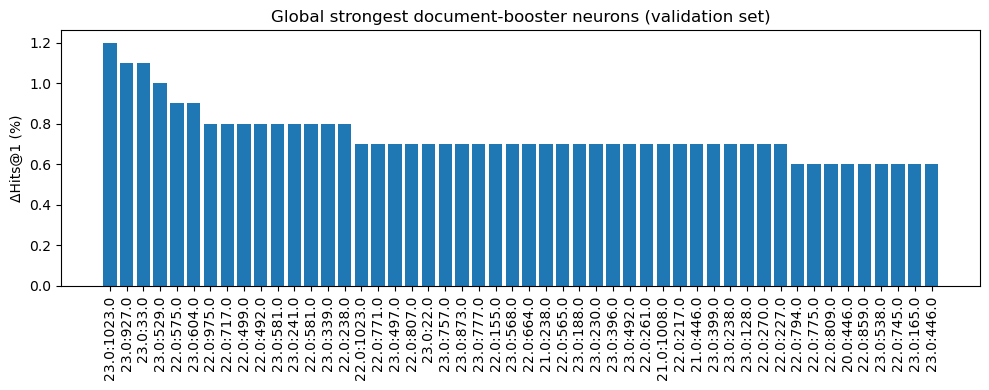

In [39]:
# ────────────────────────────────────────────────────────────────────────
# Step 9 · Visual diagnostics
# Purpose: bar-plot ΔHits@1 for top boosters (no labels needed).
# ────────────────────────────────────────────────────────────────────────
top_plot = df_boost.head(50)
plt.figure(figsize=(10,4))
plt.bar([f"{r.layer}:{r.neuron}" for _, r in top_plot.iterrows()],
        top_plot.drop_frac * 100)
plt.ylabel("ΔHits@1 (%)")
plt.title("Global strongest document-booster neurons (validation set)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [41]:
# ────────────────────────────────────────────────────────────────────────
# Step 10 – Build query–neuron flip catalogue
# Purpose: collect every (query, neuron, layer) where mean‐ or zero‐patch
#          flips the Top-1, for downstream labeling in Experiment 2.
# ────────────────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
from collections import Counter

# assumes STAGE3, NQ, queries, and your flip‐matrix files in ./flips are already set up
# and that you've loaded:
#   BASE_TOP = torch.load("BASE_TOP.pt").numpy()
#   d_mlp    = next(iter(means.values())).shape[0]
#   STAGE3   = [18,19,20,21,22,23]

records = []
for L in STAGE3:
    # map mean/zero flip bools back into memory
    fm_mean = np.memmap(f"label_flips/L{L}_mean.npy", dtype=bool, mode="r",
                        shape=(NQ, d_mlp))
    fm_zero = np.memmap(f"label_flips/L{L}_zero.npy", dtype=bool, mode="r",
                        shape=(NQ, d_mlp))
    for i, q in enumerate(queries):
        for n in range(d_mlp):
            m, z = int(fm_mean[i, n]), int(fm_zero[i, n])
            if m or z:
                records.append({
                    "layer":     L,
                    "neuron":    n,
                    "query":     q,
                    "drop_mean": m,
                    "drop_zero": z
                })

df = pd.DataFrame(records)
df.to_csv("neuron_query_flips_interesting.csv", index=False)
print("✓ wrote neuron_query_flips_interesting.csv  | rows =", len(df))

✓ wrote neuron_query_flips_interesting.csv  | rows = 12073


In [ ]:
"""
Experiment 2 – Label-Specific “Document-Booster” Neurons
Goal: Given the validation query set and your pre-computed flip-matrices, discover which decoder-MLP neurons selectively flip the Top-1 document for each semantic label (music, biology, politics, …).
TLDR:
	1.	Zero-shot-label every validation query
	2.	Merge those labels into your existing flip events
	3.	Compute per-neuron precision, recall & F1
	4.	Heat-map the most label-specific neurons
    
"""

In [35]:
# Step 1 – Zero-Shot Label Every Validation Query
# Purpose: Assign each validation query a semantic label for downstream grouping.

import json
from transformers import pipeline
from tqdm.auto import tqdm

DOMAINS = [
    # Creative / entertainment
    "music","film_tv","literature","video_games","performing_arts",
    "culture","fashion","art_architecture",
    # Sport
    "sports","olympics","esports",
    # History / society
    "history","politics","law","military","religion","philosophy",
    # Science & tech
    "biology","medicine","chemistry","physics","astronomy",
    "mathematics","technology","computer_science","environment",
    "earth_science","weather_climate",
    # Economy & business
    "economics","finance","business_companies","marketing",
    # Everyday life
    "food_cooking","transportation","education","health_fitness",
    "nature_wildlife","animals","plants",
    # Fallback
    "misc"
]

ZS_MODEL   = "MoritzLaurer/deberta-v3-large-zeroshot-v2.0"
THRESHOLD  = 0.3
BATCH_SIZE = 32

# load validation queries
val     = json.load(open("NQ10k/val_queries-10000-7423.json"))
queries = [ex["query"] for ex in val]

pipe = pipeline(
    "zero-shot-classification",
    model=ZS_MODEL,
    device=0 if __import__("torch").cuda.is_available() else -1,
    batch_size=BATCH_SIZE
)

query2label = {}
for i in tqdm(range(0, len(queries), BATCH_SIZE), desc="Z-Shot Labeling"):
    batch = queries[i : i + BATCH_SIZE]
    outs  = pipe(batch, DOMAINS, multi_label=True)
    for q, out in zip(batch, outs):
        lab, score = out["labels"][0], out["scores"][0]
        query2label[q] = lab if score >= THRESHOLD else "misc"

json.dump(query2label, open("query2label.json", "w"), indent=2)
print("✓ Wrote query2label.json:", len(query2label), "entries")

Device set to use cuda:0


Z-Shot Labeling:   0%|          | 0/32 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✓ Wrote query2label.json: 1000 entries


In [42]:
# Step 2 – Merge Labels into Flip-Event CSV
# Purpose: Annotate each flip event with its query’s semantic label.
import pandas as pd
import json

df = pd.read_csv("neuron_query_flips_interesting.csv")
q2l = json.load(open("query2label.json"))

df["label"] = df["query"].map(q2l)
df = df[df["label"] != "misc"]  # drop low-confidence misc
df.to_csv("neuron_query_flips_labeled.csv", index=False)
print("✓ Wrote neuron_query_flips_labeled.csv:", len(df), "rows")

✓ Wrote neuron_query_flips_labeled.csv: 11800 rows


In [43]:
# Step 3 – Compute Per-Neuron × Label Statistics
# Purpose: For each neuron and label, compute:
#   • precision = (# flips on that label) / (total flips by that neuron)
#   • recall    = (# flips on that label) / (total flips for that label)
#   • F1        = 2 * (precision·recall) / (precision+recall)

import pandas as pd
from collections import defaultdict

df = pd.read_csv("neuron_query_flips_labeled.csv")

# Count flips per (layer, neuron, label)
counts = defaultdict(lambda: defaultdict(int))
totals = defaultdict(int)
for _, row in df.iterrows():
    key = (row.layer, row.neuron)
    counts[key][row.label] += 1
    totals[key]            += 1

records = []
# Precompute how many flips each label has overall
label_totals = df["label"].value_counts().to_dict()

for (L, n), labdict in counts.items():
    neuron_total = totals[(L, n)]
    for lab, cnt in labdict.items():
        precision = cnt / neuron_total
        recall    = cnt / label_totals[lab]
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0.0
        records.append({
            "layer":     L,
            "neuron":    n,
            "label":     lab,
            "flips":     cnt,
            "precision": precision,
            "recall":    recall,
            "F1":        f1
        })

stats = pd.DataFrame(records)
stats.to_csv("neuron_label_stats.csv", index=False)
print("✓ Wrote neuron_label_stats.csv:", len(stats), "rows")

✓ Wrote neuron_label_stats.csv: 10976 rows


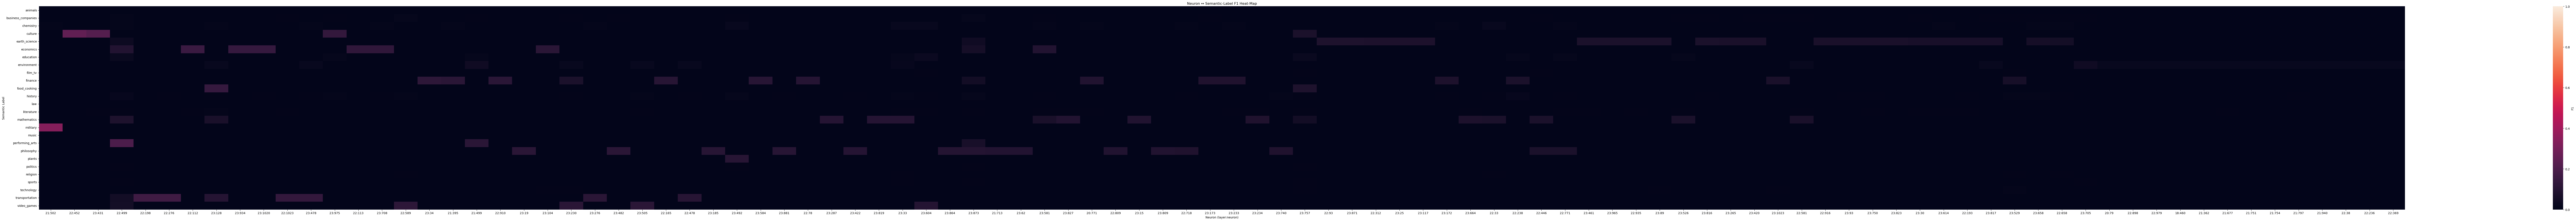

In [50]:
# Step 4 – Heat-Map of Most Label-Specific Neurons
# Purpose: Visualize top-N neurons by F1 for each label.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

stats = pd.read_csv("neuron_label_stats.csv")
topN  = 100

# pick one best label per neuron, then top-N neurons overall
best_per_neuron = (
    stats.sort_values("F1", ascending=False)
         .groupby(["layer","neuron"])
         .first()
         .reset_index()
)
top_neurons = best_per_neuron.nlargest(topN, "F1")[["layer","neuron"]]

labels = sorted(stats.label.unique())
matrix = []
for lab in labels:
    row = []
    for _, r in top_neurons.iterrows():
        rec = stats[
            (stats.layer==r.layer)&
            (stats.neuron==r.neuron)&
            (stats.label==lab)
        ]
        row.append(rec.F1.values[0] if not rec.empty else 0.0)
    matrix.append(row)

plt.figure(figsize=(1.4*topN, 0.4*len(labels)))
sns.heatmap(
    matrix,
    xticklabels=[f"{L}:{n}" for L,n in top_neurons.values],
    yticklabels=labels,
    vmin=0, vmax=1,
    cbar_kws={"label":"F1"}
)
plt.title("Neuron ↔ Semantic-Label F1 Heat-Map")
plt.xlabel("Neuron (layer:neuron)")
plt.ylabel("Semantic Label")
plt.tight_layout()
plt.show()

In [44]:
"""
Experiment 3 – Domain-Specific Neuron Group Evaluation

Goal: Test whether the top-K neurons for each semantic label, acting together, selectively degrade retrieval for that label while leaving others intact.
TLDR: Pick the K most label-precise neurons → recompute Top-1 under “mean” & “zero” patches of that group → measure on-domain vs off-domain ΔHits@1.
Outcome: domain_group_eval.csv + console output showing for each label & patch the drop in Hits@1 on-domain vs off-domain
"""

'\nExperiment 3 – Domain-Specific Neuron Group Evaluation\n\nGoal: Test whether the top-K neurons for each semantic label, acting together, selectively degrade retrieval for that label while leaving others intact.\nTLDR: Pick the K most label-precise neurons → recompute Top-1 under “mean” & “zero” patches of that group → measure on-domain vs off-domain ΔHits@1.\nOutcome: domain_group_eval.csv + console output showing for each label & patch the drop in Hits@1 on-domain vs off-domain\n'

In [51]:
# Step 1 · Select Top-K Neurons per Label
# Purpose: For each label, keep the K neurons with highest precision from neuron_label_stats.csv.

import pandas as pd

K      = 25
METRIC = "precision"   # could also use "F1" or "recall"

stats = pd.read_csv("neuron_label_stats.csv")
# sort by label then descending precision, take top K per label
group_sel = (
    stats
    .sort_values([ "label", METRIC ], ascending=[ True, False ])
    .groupby("label")
    .head(K)
    .reset_index(drop=True)
)

group_sel.to_csv("topK_neurons_per_label.csv", index=False)
print(f"✓ Wrote topK_neurons_per_label.csv ({len(group_sel)} rows)")

✓ Wrote topK_neurons_per_label.csv (452 rows)


In [52]:
# Step 2 · Helper to Recompute Top-1 under Custom Hooks
# Purpose: Given a list of hook functions (patches), rerun retrieval to get new Top-1 doc-tokens.

import numpy as np
import torch

BATCH = 256

def run_top1(hooks=None):
    """
    Returns an np.int32 array of shape (NQ,) giving the Top-1 doc-token
    for each validation query, under the given TransformerLens hooks.
    """
    out = np.empty(len(queries), dtype=np.int32)
    with model.hooks(hooks or []):
        for i in range(0, len(queries), BATCH):
            batch = queries[i:i+BATCH]
            ids   = toks(batch)
            dec   = torch.zeros((len(ids), 1), dtype=torch.long, device=device)
            with torch.inference_mode():
                logits = model(ids, dec, return_type="logits")
            out[i:i+len(ids)] = logits.argmax(-1)[:,0].cpu().numpy()
    return out

In [57]:
# Step 3 · Group-Patch Evaluation (mean & zero)
# Purpose: For each label, jointly patch its top-K neurons and measure:
#   drop_domain  = fraction of that label’s queries whose Top-1 changed
#   drop_other   = fraction of *other* labels’ queries whose Top-1 changed

import json
import pandas as pd

BASE_TOP = torch.load("baseline_top.pt").numpy()
means    = torch.load("stage3_means.pt")  # mean activations
q2l      = json.load(open("query2label.json"))

# original label per validation query
orig_labels = np.array([q2l[q] for q in queries])
labels      = sorted(set(orig_labels) - {"misc"})

def build_hooks(rows, patch="mean"):
    """
    rows: DataFrame with columns [layer, neuron]
    patch: "mean" or "zero"
    """
    hooks = []
    for L, n in rows[["layer","neuron"]].values:
        key = f"decoder.{L}.hook_mlp_out"
        val = 0.0 if patch=="zero" else float(means[L][n])
        def fn(act, *, hook, idx=n, v=val):
            act[..., idx] = v
            return act
        hooks.append((key, fn))
    return hooks

results = []
print(f">>> Evaluating each label with K = {K} neurons\n")
for lab in labels:
    sel = group_sel[group_sel.label==lab]
    mask_lab = (orig_labels == lab)
    for patch in ("mean", "zero"):
        hooks = build_hooks(sel, patch)
        pred  = run_top1(hooks)
        drop_dom   = ((pred != BASE_TOP) &  mask_lab).mean()
        drop_other = ((pred != BASE_TOP) & ~mask_lab).mean()
        results.append({
            "label":       lab,
            "patch":       patch,
            "k":           K,
            "drop_domain": round(float(drop_dom), 4),
            "drop_other":  round(float(drop_other),4)
        })
        print(f"{lab:<16} {patch:<4}  on-domain Δ={drop_dom:6.2%} | off-domain Δ={drop_other:6.2%}")

pd.DataFrame(results).to_csv("domain_group_eval.csv", index=False)
print(f"\n✓ Wrote domain_group_eval.csv ({len(results)} rows)")

>>> Evaluating each label with K = 25 neurons

animals          mean  on-domain Δ= 0.20% | off-domain Δ= 3.80%
animals          zero  on-domain Δ= 0.20% | off-domain Δ= 3.60%
art_architecture mean  on-domain Δ= 0.00% | off-domain Δ= 4.00%
art_architecture zero  on-domain Δ= 0.00% | off-domain Δ= 4.00%
astronomy        mean  on-domain Δ= 0.00% | off-domain Δ= 4.00%
astronomy        zero  on-domain Δ= 0.00% | off-domain Δ= 4.00%
biology          mean  on-domain Δ= 0.00% | off-domain Δ= 4.00%
biology          zero  on-domain Δ= 0.00% | off-domain Δ= 4.00%
business_companies mean  on-domain Δ= 0.10% | off-domain Δ= 3.80%
business_companies zero  on-domain Δ= 0.10% | off-domain Δ= 3.60%
chemistry        mean  on-domain Δ= 0.20% | off-domain Δ= 3.60%
chemistry        zero  on-domain Δ= 0.20% | off-domain Δ= 3.70%
culture          mean  on-domain Δ= 0.20% | off-domain Δ= 4.20%
culture          zero  on-domain Δ= 0.20% | off-domain Δ= 5.60%
earth_science    mean  on-domain Δ= 0.40% | off-domai

In [ ]:
"""
Experiment 4 – Neuron→Topic Mapping & Topic‐Group Causal Test

Goal: Flip the perspective from “which queries does each neuron flip?” to “what topic does each neuron encode?” and then test whether groups of neurons grouped by their inferred topic label act as domain‐gated retrieval switches.
TLDR:
	1.	Collect for each neuron the bag of all queries whose Top-1 it flips.
	2.	Zero-shot label each bag to assign a dominant topic to each neuron.
	3.	Group-patch the top-K neurons per inferred topic label (mean & zero) → measure on-domain vs off-domain ΔHits@1.
Outcome:

	•	bags_per_neuron.json (neurons → lists of queries)
	•	neuron2label.json (neuron → inferred topic)
	•	domain_group_eval_by_topic.csv (+ console printout showing ΔHits@1 for each topic group)
"""

In [55]:
# Step 1 · Build query bags per neuron
# Purpose: For each neuron, collect all validation queries whose Top-1 prediction flips
import json
import pandas as pd
from collections import defaultdict

df = pd.read_csv("neuron_query_flips_interesting.csv")  # from Experiment 1
bags = defaultdict(list)
for _, row in df.iterrows():
    if row.drop_mean or row.drop_zero:
        key = f"{row.layer},{row.neuron}"
        bags[key].append(row.query)

json.dump(bags, open("bags_per_neuron.json", "w"), indent=2)
print(f"✓ Wrote bags_per_neuron.json   neurons with ≥1 flip: {len(bags)}")

✓ Wrote bags_per_neuron.json   neurons with ≥1 flip: 4773


In [56]:
# Step 2 · Zero‐shot label each neuron’s bag (majority vote)
# Purpose: Assign each neuron the semantic label most represented among the queries it flips.
import json
from tqdm.auto import tqdm
from transformers import pipeline

DOMAINS = [
    "music","film_tv","literature","video_games","performing_arts",
    "sports","olympics","esports",
    "history","politics","law","military","religion","philosophy",
    "biology","medicine","chemistry","physics","astronomy",
    "mathematics","technology","computer_science",
    "geography","earth_science","environment","animals",
    "plants","weather_climate",
    "economics","finance","business_companies","marketing",
    "food_cooking","transportation","education","fashion",
    "health_fitness","culture","misc"
]
ZS_MODEL = "MoritzLaurer/deberta-v3-large-zeroshot-v2.0"
THR      = 0.3
BATCH    = 64

bags = json.load(open("bags_per_neuron.json"))
pipe = pipeline("zero-shot-classification", model=ZS_MODEL,
                device=0 if torch.cuda.is_available() else -1,
                batch_size=BATCH)

neuron2label = {}
for neuron_key, queries_list in tqdm(bags.items(), desc="Labelling neurons"):
    votes = []
    for i in range(0, len(queries_list), BATCH):
        chunk = queries_list[i:i+BATCH]
        outs  = pipe(chunk, DOMAINS, multi_label=True)
        for out in outs:
            lab, sc = out["labels"][0], out["scores"][0]
            if sc >= THR:
                votes.append(lab)
    neuron2label[neuron_key] = max(set(votes), key=votes.count) if votes else "misc"

json.dump(neuron2label, open("neuron2label.json", "w"), indent=2)
print("✓ Wrote neuron2label.json   unique labels:", sorted(set(neuron2label.values())))

Device set to use cuda:0


Labelling neurons:   0%|          | 0/4773 [00:00<?, ?it/s]

✓ Wrote neuron2label.json   unique labels: ['animals', 'chemistry', 'earth_science', 'economics', 'education', 'film_tv', 'finance', 'geography', 'history', 'law', 'literature', 'mathematics', 'misc', 'music', 'performing_arts', 'philosophy', 'politics', 'religion', 'sports', 'technology', 'transportation']


In [59]:
# Step 3 · Topic‐Group Evaluation (mean & zero)
# Purpose: For each inferred topic, jointly patch its top-K neurons and measure ΔHits@1.
import json
import numpy as np
import pandas as pd
import torch

# load artifacts
BASE_TOP = torch.load("baseline_top.pt").numpy()
means    = torch.load("stage3_means.pt")
neuron2label = json.load(open("neuron2label.json"))

# invert mapping → topic → list of (layer,neuron)
topic_groups = {}
for k, lab in neuron2label.items():
    topic_groups.setdefault(lab, []).append(tuple(map(int, k.split(","))))

K = 25
labels = [lab for lab in topic_groups if lab != "misc"]
results = []

def build_hooks(neuron_list, patch="mean"):
    hooks = []
    for L, n in neuron_list[:K]:
        key = f"decoder.{L}.hook_mlp_out"
        val = 0.0 if patch=="zero" else float(means[L][n])
        def fn(act, *, hook, idx=n, v=val):
            act[..., idx] = v
            return act
        hooks.append((key, fn))
    return hooks

for lab in labels:
    group = topic_groups[lab]
    for patch in ("mean", "zero"):
        hooks = build_hooks(group, patch)
        preds = run_top1(hooks)   # reuse helper from Exp3
        drop_dom   = ((preds != BASE_TOP) & \
                      np.isin([q2l[q] for q in queries], lab)).mean()
        drop_other = ((preds != BASE_TOP) & \
                      ~np.isin([q2l[q] for q in queries], lab)).mean()
        results.append({
            "topic":      lab,
            "patch":      patch,
            "k":          min(K, len(group)),
            "drop_topic": round(drop_dom,4),
            "drop_other": round(drop_other,4)
        })
        print(f"{lab:<16} {patch:<4}  topic Δ={drop_dom:6.2%} | other Δ={drop_other:6.2%}")

pd.DataFrame(results).to_csv("domain_group_eval_by_topic.csv", index=False)
print(f"✓ Wrote domain_group_eval_by_topic.csv ({len(results)} rows)")

religion         mean  topic Δ= 0.20% | other Δ= 4.20%
religion         zero  topic Δ= 0.20% | other Δ= 4.30%
animals          mean  topic Δ= 0.20% | other Δ= 3.50%
animals          zero  topic Δ= 0.20% | other Δ= 4.00%
law              mean  topic Δ= 0.00% | other Δ= 4.00%
law              zero  topic Δ= 0.00% | other Δ= 4.10%
geography        mean  topic Δ= 0.00% | other Δ= 4.30%
geography        zero  topic Δ= 0.00% | other Δ= 4.50%
technology       mean  topic Δ= 0.30% | other Δ= 3.60%
technology       zero  topic Δ= 0.30% | other Δ= 3.90%
music            mean  topic Δ= 0.30% | other Δ= 3.80%
music            zero  topic Δ= 0.30% | other Δ= 3.70%
sports           mean  topic Δ= 0.40% | other Δ= 3.50%
sports           zero  topic Δ= 0.40% | other Δ= 3.50%
film_tv          mean  topic Δ= 0.70% | other Δ= 3.90%
film_tv          zero  topic Δ= 0.70% | other Δ= 3.60%
politics         mean  topic Δ= 0.40% | other Δ= 3.50%
politics         zero  topic Δ= 0.40% | other Δ= 3.60%
history   